In [6]:
import pandas as pd
import json
import argparse
import random
import numpy as np
from scipy import ndimage


from utils.data_split import patient_split

with open("_info/default_path.json", 'r') as file:
            default_dirs = json.load(file)

if __name__=='__main__':
        
    parser = argparse.ArgumentParser(description="ExpertDT Test")

    parser.add_argument("--root_dir", type=str, default=default_dirs['root_dir'], help="Root WSIs Folder")
    parser.add_argument("--ids_dir", type=str, default=default_dirs['ids_dir'], help="Path to Patient IDs File")
    parser.add_argument("--split_dir", type=str, default=default_dirs['split_dir'], help="Patient args.level Train/Test Split")
    parser.add_argument("--split_ids_dir", type=str, default=default_dirs['split_ids_dir'], help="Split Data IDs")

    # Load ID Split List
    parser.add_argument("--load_id_list", type=bool, default=True, help="Load ID Split List, False Results to Create and Save New List File")

    # Verbose Argument
    parser.add_argument("--verbose", type=bool, default=True, help="Verbose Print Details")

    # Cropping Arguments
    parser.add_argument("--crop_size", type=int, default=1000, help="Patches Crop Size During Cropping Stage")
    parser.add_argument("--wsi_args.level", type=int, default=0, help="Whole Slide Image args.level of Magnification During Cropping Stage")
    parser.add_argument("--overlap", type=int, default=1, help="Patches args.overlap During Cropping Stage; 1: No args.overlap, 2: 50%, etc.")
    parser.add_argument("--wsi_formats", nargs=3, type=str, default=['scn', 'svs', 'tif'], help="Possible Formats for Whole Slide Image")

    parser.add_argument("--random_seed", type=int, default=42, help="Random Seed for Reproducibility")

    args = parser.parse_args(args=[])

    random.seed(args.random_seed)


In [7]:
if args.verbose:
    print("\n>>> Loading Patient IDs ...\n")

ids_df = pd.read_csv(args.ids_dir)


>>> Loading Patient IDs ...



In [8]:
try:
    with open(args.split_dir, 'r') as file:
        split_ratio = json.load(file)
except:
    raise FileNotFoundError("No Split Ratio JSON File in './_info/' folder.")

if args.verbose:
    print(pd.DataFrame(split_ratio))

            Train  Test
ccRCC          33    23
pRCC           15     7
CHROMO          3     3
ONCOCYTOMA      3     4


In [9]:
if args.verbose:
    print("\n>>> Loading/Creating Train Test ID Split File ...")

train_test_ids = patient_split(data_df=ids_df,
                                split_ratio=split_ratio,
                                random_seed=args.random_seed,
                                load=args.load_id_list,
                                ids_dir=args.split_ids_dir)


>>> Loading/Creating Train Test ID Split File ...
>>> Loading Split IDs from '_info/split_ids.json'!


In [10]:
train_test_ids['Test']

{'ccRCC': [1,
  2,
  7,
  10,
  14,
  18,
  20,
  21,
  22,
  23,
  28,
  29,
  35,
  37,
  38,
  39,
  40,
  42,
  43,
  45,
  49,
  51,
  55],
 'pRCC': [62, 63, 65, 66, 70, 75, 77],
 'CHROMO': [78, 79, 80],
 'ONCOCYTOMA': [84, 85, 89, 90]}

In [11]:
# Define the initial classification numpy array
input_image = np.array([
    [1, 1, 0, 0, 0],
    [1, 0, 0, 0, 1],
    [0, 0, 1, 1, 1],
    [0, 1, 1, 0, 0],
    [1, 1, 0, 0, 1]
])

def _most_frequent(x):
    central = x[x.size // 2]
    values, counts = np.unique(x, return_counts=True)
    max_freq = counts.max()
    modes = values[counts == max_freq]
    if central in modes:
        return central
    else:
        return modes[0]

size = (3, 3)  # Defining the neighborhood size

# Apply the refinement function
refined_image = ndimage.generic_filter(input_image, _most_frequent, size=size)

input_image, refined_image

(array([[1, 1, 0, 0, 0],
        [1, 0, 0, 0, 1],
        [0, 0, 1, 1, 1],
        [0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1]]),
 array([[1, 1, 0, 0, 0],
        [1, 0, 0, 0, 1],
        [0, 0, 0, 1, 1],
        [0, 1, 1, 1, 1],
        [1, 1, 0, 0, 0]]))

In [4]:
import os
import tensorflow as tf
from keras.applications import VGG16
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model

class Vgg16:
    def __init__(self, input_shape, n_classes, first_trained_layer=None, save_dir='_weights'):

        self.input_shape = input_shape
        self.n_classes = n_classes
        self.first_trained_layer = first_trained_layer
        self.model = self.build_model()
        self.save_dir = save_dir

    def build_model(self):

        vgg16 = VGG16(include_top=False, input_shape=self.input_shape, weights='imagenet')

        # Freeze the specified first layers
        if self.first_trained_layer is not None:
            for layer in vgg16.layers[:self.first_trained_layer]:
                layer.trainable = False

        x = vgg16.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x) 
        x = Dropout(0.5)(x)
        predictions = Dense(self.n_classes, activation='softmax')(x) 

        # Creating the final model
        model = Model(inputs=vgg16.input, outputs=predictions)

        return model

    def compile(self,
                learning_rate=1e-5,
                loss='categorical_crossentropy',
                metrics=['accuracy']):
        
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                           loss=loss,
                           metrics=metrics)

    def fit(self, data, epochs, callbacks):

        self.model.fit(data,
                       epochs=epochs,
                       callbacks=[callbacks])

    def summary(self):
        self.model.summary()

    def save_weights(self):

        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        
        # Define the path for saving the weights
        weights_path = os.path.join(self.save_dir, 'vgg16_weights.h5')
        
        # Save the model's weights
        self.model.save_weights(weights_path)
        print(f'Model weights saved to: {weights_path}')

    def load_weights(self, weights_path):

        self.model.load_weights(weights_path)
        print(f'>>> Succesfully Loaded Weights ...')

    def predict(self, input):

        if input.ndim == 3:
            input = np.expand_dims(input, axis=0)

        predictions = self.model.predict(input, verbose=0)

        return predictions

In [5]:

        # if stage=="Root":
        #     arrays = [self.root_array, self.root_refined_array]
        #     titles = ['Root', 'Refined Root']
        #     stage_colors = [(0.5, 0.5, 0.5, alpha), (0, 1, 0, alpha), (1, 1, 0, alpha)]
        #     ytick_labels = ['-1 (Background)', '0 (Tumor)', '1 (Non-Tumor)']
        #     label_dict = {"-1": "Background", "0": "Non-Tumor", "1": "Tumor"}

        # elif stage=="Node":
        #     arrays = [self.node_array, self.node_refined_array]
        #     titles = ['Node', 'Refined Node']
        #     stage_colors = [(0.5, 0.5, 0.5, alpha), (0, 0, 1, alpha), (1, 0, 0, alpha)]
        #     ytick_labels = ['-1 (Background)', '0 (ccRCC/pRCC)', '1 (CHROMO/ONCO)']
        #     label_dict = {"-1": "Background", "0": "Non-Tumor", "1": "Tumor", "2":"CHROMO"}

        # elif stage=="Leaf1":
        #     arrays = [self.leaf1_array, self.leaf1_refined_array]
        #     titles = ['Leaf 1', 'Refined Leaf 1']
        #     stage_colors = [(0.5, 0.5, 0.5, alpha), (0.5, 0, 0.5, alpha), (0, 1, 1, alpha)]
        #     ytick_labels = ['-1 (Background)', '0 (CHROMO)', '1 (ONCOCYTOMA)']
        #     label_dict = {"-1": "Background", "0": "Non-Tumor", "1": "Tumor", "2":"CHROMO"}

        # elif stage=="Leaf2":
        #     arrays = [self.leaf2_array, self.leaf2_refined_array]
        #     titles = ['Leaf 2', 'Refined Leaf 2']
        #     stage_colors = [(0.5, 0.5, 0.5, alpha), (1, 0.5, 0, alpha), (1, 0.75, 0.8, alpha)]
        #     ytick_labels = ['-1 (Background)', '0 (ccRCC)', '1 (pRCC)']
        #     label_dict = {"-1": "Background", "0": "Non-Tumor", "1": "Tumor", "2":"CHROMO"}

In [6]:
class PlotTree:

    def __init__(self):
        
        self.plot_dict = {}

    def PlotStage(self, stage, alpha):

        self.colors_rgba = {
                                "Red": (1.0, 0.0, 0.0, alpha),
                                "Orange": (1.0, 0.5, 0.0, alpha),
                                "Yellow": (1.0, 1.0, 0.0, alpha),
                                "Lime Green": (0.5, 1.0, 0.0, alpha),
                                "Green": (0.0, 1.0, 0.0, alpha),
                                "Spring Green": (0.0, 1.0, 0.5, alpha),
                                "Cyan": (0.0, 1.0, 1.0, alpha), 
                                "Blue": (0.0, 0.0, 1.0, alpha),
                                "Purple": (0.5, 0.0, 1.0, alpha),
                                "Magenta": (1.0, 0.0, 1.0, alpha),
                                "Pink": (1.0, 0.75, 0.8, alpha),
                                "Dark Red": (0.6, 0.0, 0.0, alpha),
                                "White": (1.0, 1.0, 1.0, alpha)
                            }

        self.plot_dict = {
            
            "Root": {
                "titles": ['Root', 'Refined Root'],
                "stage_colors": [self.colors_rgba['White'], self.colors_rgba['Pink'], self.colors_rgba['Dark Red']],
                "label_dict": {"0": "Background", "1": "Non-Tumor", "2": "Tumor"}

            },

            "Node": {
                "titles": ['Node', 'Refined Node'],
                "stage_colors": [self.colors_rgba['White'], self.colors_rgba['Pink'], self.colors_rgba['Blue'], self.colors_rgba['Orange']],
                "label_dict": {"0": "Background", "1": "Non-Tumor", "2": "CHROMO/ONCO", "3": "ccRCC/pRCC"}

            },

            "Leaf1": {
                "titles": ['Leaf1', 'Refined Leaf1'],
                "stage_colors": [ self.colors_rgba['White'], self.colors_rgba['Pink'], "", "", self.colors_rgba['Purple'], self.colors_rgba['Magenta']],
                "label_dict": {"0": "Background", "1": "Non-Tumor", "4": "CHROMO", "5": "ONCOCYTOMA"}

            },

            "Leaf2": {
                "titles": ['Leaf2', 'Refined Leaf2'],
                "stage_colors": [self.colors_rgba['White'], self.colors_rgba['Pink'], self.colors_rgba['Lime Green'], self.colors_rgba['Cyan']],
                "label_dict": {"0": "Background", "1": "Non-Tumor", "2": "ccRCC", "3": "pRCC"}

            }
        }

        return self.plot_dict[stage]

In [7]:
import os
from glob import glob
import math
import pandas as pd
import numpy as np
import time
import json
from tqdm import tqdm
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from concurrent.futures import ThreadPoolExecutor, as_completed

OPENSLIDE_PATH = r'D:\Openslide\Openslide\openslide-win64-20231011\bin'

if hasattr(os, 'add_dll_directory'):
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

class ExpertDT:
    
    def __init__(self, crop_size=1000,
                 crop_resize=112,
                 level=0,
                 overlap=1,
                 batch_size=128,
                 weights_dir='_weights',
                 tree_pair_dir='_info',
                 pruned_threshold=30,
                 save_fig=True):

        self.crop_size = crop_size
        self.crop_resize = crop_resize
        self.level = level
        self.overlap = overlap
        self.batch_size = batch_size
        self.weights_dir = weights_dir
        self.n_classes = 2
        self.first_trained_layer = 11
        self.tree_pair_dir = tree_pair_dir
        self.node_pruned_threshold = pruned_threshold
        self.save_fig = save_fig

        self.stages_status = {
                                "Root": "Not Defined",
                                "Node": "Not Defined",
                                "Leaf1": "Not Defined",
                                "Leaf2": "Not Defined",
                            }

        self.load_tree_pair_dict()
        self.load_tree_weights()

    def load_tree_pair_dict(self):

        with open(f"{self.tree_pair_dir}/tree_pair_dict.json", 'r') as file:
            self.tree_pair_dict = json.load(file)   

    def process_patch(self, args):

        x, y, _step_, bounds_y, bounds_x, _size_ = args
        if x * _step_ + self.crop_size > self.bounds_width or y * _step_ + self.crop_size > self.bounds_height:
            return None
        _top_ = _step_ * y + bounds_y
        _left_ = _step_ * x + bounds_x

        _patch_ = {'x': x, 'y': y, 'top': _top_, 'left': _left_, 'size': _size_}
        
        if not self.check_background(_patch_):
            _label_ = 1
        else:
            _label_ = 0
        _patch_['label'] = _label_

        return _patch_

    def init_patches(self, slide_dir):

        print(">>> Start Slide Analysis ...")

        self.slide = openslide.OpenSlide(slide_dir)
        downsample = self.slide.level_downsamples[self.level]
        self.bounds_width, self.bounds_height = self.slide.dimensions if 'openslide.bounds-width' not in self.slide.properties else (int(self.slide.properties['openslide.bounds-width']), int(self.slide.properties['openslide.bounds-height']))
        bounds_x, bounds_y = (0, 0) if 'openslide.bounds-x' not in self.slide.properties else (int(self.slide.properties['openslide.bounds-x']), int(self.slide.properties['openslide.bounds-y']))

        _step_ = int(self.crop_size / self.overlap)
        _size_ = math.floor(self.crop_size / downsample)
        _y_steps_ = int(math.ceil((self.bounds_height - self.crop_size) / _step_))
        _x_steps_ = int(math.ceil((self.bounds_width - self.crop_size) / _step_))

        patch_args = [(x, y, _step_, bounds_y, bounds_x, _size_) for y in range(_y_steps_) for x in range(_x_steps_)]

        self.patches_dict = []
        self.slide_array = np.zeros((_y_steps_, _x_steps_))

        print("[Step 1/4] >>> Cropping WSI into patches ...")

        with tqdm(total=len(patch_args)) as pbar:
            with ThreadPoolExecutor(max_workers=4) as executor:
                futures = [executor.submit(self.process_patch, arg) for arg in patch_args]
                for future in as_completed(futures):
                    result = future.result()
                    if result is not None:
                        self.patches_dict.append(result)
                        self.slide_array[result['y'], result['x']] = result['label']
                    pbar.update(1)

        self.patches_dict = list(self.patches_dict)    
    
    @staticmethod
    def is_background(region, threshold=210):

        if np.mean(region) > threshold:
            return True
        else:
            return False
        
    def check_background(self, patch):

        region = self.slide.read_region([patch['left'],
                                                    patch['top']],
                                                self.level,
                                                [patch['size'],
                                                    patch['size']])
        
        region = region.convert('RGB').resize(size=(self.crop_resize, self.crop_resize))

        return self.is_background(region)
    
    def _refine(self, input):
        
        central = input[input.size // 2]
        values, counts = np.unique(input, return_counts=True)
        max_freq = counts.max()
        modes = values[counts == max_freq]
        
        if central==0:
            return 0
        elif central in modes:
            return central
        else:
            return modes[0]
        
    def refine_output(self, input_crops, size=(3, 3)):

        refined_crops = ndimage.generic_filter(input_crops, self._refine, size=size)

        return refined_crops
    
    def load_tree_weights(self):

        stage_folders = [os.path.join(self.weights_dir, f) for f in os.listdir(self.weights_dir) if os.path.isdir(os.path.join(self.weights_dir, f))]

        self.final_weights = {}

        for stage in stage_folders:

            files = glob(os.path.join(stage, '*'))
            
            if files:

                files.sort(key=os.path.getmtime, reverse=True)
                latest_update = os.path.basename(files[0])
                self.final_weights[os.path.basename(stage)] = latest_update

    def check_stage_requirement(self, stage):

        if stage == "Node":
            if self.stages_status["Root"] != "Not Defined":
                return True
            else:
                return False
        
        elif stage == "Leaf1" or stage == "Leaf2" :
            if self.stages_status["Node"] != "Not Defined":
                return True
            else:
                return False
            
    def predict_root(self):
        
        vgg16 = Vgg16(input_shape=(self.crop_resize, self.crop_resize, 3),
                      n_classes=self.n_classes,
                      first_trained_layer=self.first_trained_layer)
        
        vgg16.load_weights(weights_path=f"{self.weights_dir}/Root/{self.final_weights['Root']}")

        self.root_array = self.slide_array.copy()

        image_batch = []
        patch_indices = []

        def process_batch(batch, indices):
            if batch:
                pred_labels = vgg16.predict(np.array(batch))
                pred_classes = np.argmax(pred_labels, axis=1)
                for pred_class, index in zip(pred_classes, indices):
                    self.root_array[self.patches_dict[index]['y'], self.patches_dict[index]['x']] = pred_class+1

        print("[Step 2/4] >>> Root Stage Analysis ...")

        for patch_index in tqdm(range(len(self.patches_dict))):

            root_condition = self.patches_dict[patch_index]['label'] != 0

            if root_condition:
                region = self.slide.read_region([self.patches_dict[patch_index]['left'],
                                                 self.patches_dict[patch_index]['top']],
                                                self.level,
                                                [self.patches_dict[patch_index]['size'],
                                                 self.patches_dict[patch_index]['size']])
                region = region.convert('RGB').resize(size=(self.crop_resize, self.crop_resize))
                image_array = np.array(region) / 255.0

                image_batch.append(image_array)
                patch_indices.append(patch_index)

                if len(image_batch) == self.batch_size:
                    process_batch(image_batch, patch_indices)
                    image_batch = []
                    patch_indices = []

        process_batch(image_batch, patch_indices)

        self.root_refined_array = self.refine_output(self.root_array)
        self.stages_status['Root'] = "Done"

    def predict_node(self):
        
        if not self.check_stage_requirement(stage="Node"):
            print("[WARNING] No Root Analysis Found ...")
            return

        vgg16 = Vgg16(input_shape=(self.crop_resize, self.crop_resize, 3),
                      n_classes=self.n_classes,
                      first_trained_layer=self.first_trained_layer)
        
        vgg16.load_weights(weights_path=f"{self.weights_dir}/Node/{self.final_weights['Node']}")

        self.node_array = self.root_refined_array.copy()

        print("[Step 3/4] >>> Node Stage Analysis ...")
        
        image_batch = []
        patch_info_batch = []

        def process_batch(batch, info_batch):
            if not batch:
                return
            
            pred_labels = vgg16.predict(np.array(batch))
            pred_classes = np.argmax(pred_labels, axis=1)
            
            for pred_class, info in zip(pred_classes, info_batch):
                y, x, patch_index = info
                if pred_class == 0:
                    node_label = 3
                else:
                    node_label = 2
                self.node_array[y, x] = node_label

        for patch_index in tqdm(range(len(self.patches_dict))):
            root_crop_label = self.root_refined_array[self.patches_dict[patch_index]['y'], self.patches_dict[patch_index]['x']]

            if root_crop_label == 2:
                region = self.slide.read_region([self.patches_dict[patch_index]['left'],
                                                 self.patches_dict[patch_index]['top']],
                                                self.level,
                                                [self.patches_dict[patch_index]['size'],
                                                 self.patches_dict[patch_index]['size']])
                region = region.convert('RGB').resize(size=(self.crop_resize, self.crop_resize))
                image_array = np.array(region) / 255.0

                image_batch.append(image_array)
                patch_info_batch.append((self.patches_dict[patch_index]['y'], self.patches_dict[patch_index]['x'], patch_index))

                if len(image_batch) == self.batch_size:
                    process_batch(image_batch, patch_info_batch)
                    image_batch = []
                    patch_info_batch = []

        process_batch(image_batch, patch_info_batch)

        self.node_refined_array = self.refine_output(self.node_array)

        unique_values, counts = np.unique(self.node_refined_array, return_counts=True)
        value_counts = dict(zip(unique_values, counts))

        node_count_1, node_count_2 = value_counts.get(2, 0), value_counts.get(3, 0)
        self.node_cert = round(abs(node_count_1 - node_count_2) / (node_count_1 + node_count_2) * 100, 2)

        if self.node_cert >= self.node_pruned_threshold:

            node_majority = 1 if node_count_1 > node_count_2 else 2
            print(f"--- >>> Node Confidence: : {self.node_cert}%, Node to Leaf {node_majority}")
            self.stages_status['Node'] = f'Leaf{node_majority}' 
        else:
            self.stages_status['Node'] = 'Pruned'
            print("--- >>> Node is Pruned! Connecting Root Directly to Leafs ...")

    def predict_leaf1(self):

        vgg16 = Vgg16(input_shape=(self.crop_resize, self.crop_resize, 3),
                      n_classes=self.n_classes,
                      first_trained_layer=self.first_trained_layer)
        
        vgg16.load_weights(weights_path=f"{self.weights_dir}/Leaf1/{self.final_weights['Leaf1']}")

        self.leaf1_array = self.node_refined_array.copy()
        self.leaf1_array[self.leaf1_array == 3] = 1

        print("[Step 4/4] >>> Leaf Stage Analysis: Leaf 1 ...")
        
        image_batch = []
        patch_info_batch = []

        def process_batch(batch, info_batch):
            if not batch:
                return
            
            pred_labels = vgg16.predict(np.array(batch))
            pred_classes = np.argmax(pred_labels, axis=1)
            
            for pred_class, info in zip(pred_classes, info_batch):
                y, x, patch_index = info
                if pred_class == 0:
                    leaf1_label = 4
                else:
                    leaf1_label = 5

                self.leaf1_array[y, x] = leaf1_label

        for patch_index in tqdm(range(len(self.patches_dict))):

            node_crop_label = self.node_refined_array[self.patches_dict[patch_index]['y'], self.patches_dict[patch_index]['x']]

            if node_crop_label == 2:
                region = self.slide.read_region([self.patches_dict[patch_index]['left'],
                                                 self.patches_dict[patch_index]['top']],
                                                self.level,
                                                [self.patches_dict[patch_index]['size'],
                                                 self.patches_dict[patch_index]['size']])
                
                region = region.convert('RGB').resize(size=(self.crop_resize, self.crop_resize))
                image_array = np.array(region) / 255.0

                image_batch.append(image_array)
                patch_info_batch.append((self.patches_dict[patch_index]['y'], self.patches_dict[patch_index]['x'], patch_index))

                if len(image_batch) == self.batch_size:
                    process_batch(image_batch, patch_info_batch)
                    image_batch = []
                    patch_info_batch = []

        process_batch(image_batch, patch_info_batch)

        self.leaf1_refined_array = self.refine_output(self.leaf1_array)

        unique_leaf1, count_leaf1 = np.unique(self.leaf1_refined_array, return_counts=True)
        self.value_counts_leaf1 = dict(zip(unique_leaf1, count_leaf1))
    
    def predict_leaf2(self):

        vgg16 = Vgg16(input_shape=(self.crop_resize, self.crop_resize, 3),
                      n_classes=self.n_classes,
                      first_trained_layer=self.first_trained_layer)
        
        vgg16.load_weights(weights_path=f"{self.weights_dir}/Leaf2/{self.final_weights['Leaf2']}")

        self.leaf2_array = self.node_refined_array.copy()
        self.leaf2_array[self.leaf2_array == 2] = 1

        print("[Step 4/4] >>> Leaf Stage Analysis: Leaf 2 ...")
        
        image_batch = []
        patch_info_batch = []

        def process_batch(batch, info_batch):
            if not batch:
                return
            
            pred_labels = vgg16.predict(np.array(batch))
            pred_classes = np.argmax(pred_labels, axis=1)
            
            for pred_class, info in zip(pred_classes, info_batch):
                y, x, patch_index = info
                if pred_class == 0:
                    leaf2_label = 2
                else:
                    leaf2_label = 3

                self.leaf2_array[y, x] = leaf2_label

        for patch_index in tqdm(range(len(self.patches_dict))):

            node_crop_label = self.node_refined_array[self.patches_dict[patch_index]['y'], self.patches_dict[patch_index]['x']]

            if node_crop_label == 3:
                region = self.slide.read_region([self.patches_dict[patch_index]['left'],
                                                 self.patches_dict[patch_index]['top']],
                                                self.level,
                                                [self.patches_dict[patch_index]['size'],
                                                 self.patches_dict[patch_index]['size']])
                
                region = region.convert('RGB').resize(size=(self.crop_resize, self.crop_resize))
                image_array = np.array(region) / 255.0

                image_batch.append(image_array)
                patch_info_batch.append((self.patches_dict[patch_index]['y'], self.patches_dict[patch_index]['x'], patch_index))

                if len(image_batch) == self.batch_size:
                    process_batch(image_batch, patch_info_batch)
                    image_batch = []
                    patch_info_batch = []

        process_batch(image_batch, patch_info_batch)

        self.leaf2_refined_array = self.refine_output(self.leaf2_array)

        unique_leaf2, count_leaf2 = np.unique(self.leaf2_refined_array, return_counts=True)
        self.value_counts_leaf2 = dict(zip(unique_leaf2, count_leaf2))

    def predict_leaf(self):

        if not self.check_stage_requirement(stage="Node"):
            print("[WARNING] No Root Analysis Found ...")
            return
        
        if self.stages_status['Node'] == 'Pruned':

            self.predict_leaf1()
            self.predict_leaf2()

            value_counts_leaf = {**self.value_counts_leaf1, **self.value_counts_leaf2}

            ccrcc_count, prcc_count = value_counts_leaf.get(2, 0), value_counts_leaf.get(3, 0)
            chromo_count, onco_count = value_counts_leaf.get(4, 0), value_counts_leaf.get(5, 0)

            self.subtype_counts = {
                                'ccRCC': ccrcc_count,
                                'pRCC': prcc_count,
                                'CHROMO': chromo_count,
                                'ONCOCYTOMA': onco_count
                            }
            
            self.max_subtype = max(self.subtype_counts, key=self.subtype_counts.get)

        elif self.stages_status['Node'] == 'Leaf1':

            self.predict_leaf1()

            chromo_count, onco_count = self.value_counts_leaf1.get(4, 0), self.value_counts_leaf1.get(5, 0)

            self.subtype_counts = {
                                'ccRCC': 0,
                                'pRCC': 0,
                                'CHROMO': chromo_count,
                                'ONCOCYTOMA': onco_count
                            }
            
            self.max_subtype = max(self.subtype_counts, key=self.subtype_counts.get)

        elif self.stages_status['Node'] == 'Leaf2':

            self.predict_leaf2()

            ccrcc_count, prcc_count = self.value_counts_leaf2.get(2, 0), self.value_counts_leaf2.get(3, 0)

            self.subtype_counts = {
                                'ccRCC': ccrcc_count,
                                'pRCC': prcc_count,
                                'CHROMO': 0,
                                'ONCOCYTOMA': 0
                            }
            
            self.max_subtype = max(self.subtype_counts, key=self.subtype_counts.get)

    def predict(self, slide_dir):

        self.init_patches(slide_dir)
        self.predict_root()
        self.predict_node()
        self.predict_leaf()

        print(f">>> Results:")
        print(f">>> Slide Label: {self.max_subtype}")
        print(f">>> Subtype Count:\n {self.subtype_counts}")

    def save_figs(self, save_dir, id, slidename):

        print(">>> Saving Figures ...")

        os.makedirs(f'{save_dir}/{id}/{slidename}')
        if self.save_fig:
            stages_plot = ['Root', 'Node']

            if self.stages_status['Node']=='Pruned':
                stages_plot.append('Leaf1')
                stages_plot.append('Leaf2')
            else:
                stages_plot.append(self.stages_status['Node'])

            for stage in stages_plot:
                self.save_plot_stage(stage, name_dir=f'_figs/{id}/{slidename}/{slidename}_{stage}.png', dpi=300, alpha=1)

    def save_plot_stage(self, stage, name_dir, dpi=300, alpha=1):

        if stage=="Root":
            arrays = [self.root_array, self.root_refined_array]

        elif stage=="Node":
            arrays = [self.node_array, self.node_refined_array]

        elif stage=="Leaf1":
            arrays = [self.leaf1_array, self.leaf1_refined_array]

        elif stage=="Leaf2":
            arrays = [self.leaf2_array, self.leaf2_refined_array]

        stage_kwargs = PlotTree().PlotStage(stage=stage, alpha=alpha)

        sorted_keys = sorted(stage_kwargs['label_dict'].keys(), key=int)

        labels = [stage_kwargs['label_dict'][key] for key in sorted_keys]
        colors = [stage_kwargs['stage_colors'][int(key)] for key in sorted_keys]

        cmap = ListedColormap(colors)
        bounds = [float(key) - 0.5 for key in sorted_keys] + [float(sorted_keys[-1]) + 0.5]
        norm = BoundaryNorm(bounds, cmap.N)

        fig, axes = plt.subplots(1, len(arrays), figsize=(20, 5))
        for ax, array, title in zip(axes, arrays, stage_kwargs['titles']):
            im = ax.imshow(array, cmap=cmap, norm=norm)
            ax.set_title(title)

        handles = [Patch(color=color, label=label) for color, label in zip(colors, labels)]
        plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.savefig(name_dir, bbox_inches='tight', pad_inches=0, dpi=dpi)
        plt.close()

    def plot_stage_on_slide(self, stage, alpha=1):

        if stage=="Root":
            arrays = [self.root_array, self.root_refined_array]

        elif stage=="Node":
            arrays = [self.node_array, self.node_refined_array]

        elif stage=="Leaf1":
            arrays = [self.leaf1_array, self.leaf1_refined_array]

        elif stage=="Leaf2":
            arrays = [self.leaf2_array, self.leaf2_refined_array]

        stage_kwargs = PlotTree().PlotStage(stage=stage, alpha=alpha)

        sorted_keys = sorted(stage_kwargs['label_dict'].keys(), key=int)

        labels = [stage_kwargs['label_dict'][key] for key in sorted_keys]
        colors = [stage_kwargs['stage_colors'][int(key)] for key in sorted_keys]

        cmap = ListedColormap(colors)
        bounds = [float(key) - 0.5 for key in sorted_keys] + [float(sorted_keys[-1]) + 0.5]
        norm = BoundaryNorm(bounds, cmap.N)

        fig, axes = plt.subplots(1, len(arrays), figsize=(20, 5))
        for ax, array, title in zip(axes, arrays, stage_kwargs['titles']):
            im = ax.imshow(array, cmap=cmap, norm=norm)
            ax.set_title(title)

        handles = [Patch(color=color, label=label) for color, label in zip(colors, labels)]
        plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

In [8]:
expertdt = ExpertDT(crop_size=1000,
                    crop_resize=112,
                    level=0,
                    overlap=1,
                    batch_size=128,
                    weights_dir="F:\My Files\Thesis\Dataset\_weights",
                    tree_pair_dir="_info",
                    pruned_threshold=30)

expertdt.predict(slide_dir="F:\My Files\Thesis\Dataset\RCC_WSIs\ccRCC\H19.754.IHC.ccRCC.scn")
expertdt.save_figs(save_dir='_figs',
                    id='H19.754',
                    slidename='H19.754.IHC.ccRCC')

>>> Start Slide Analysis ...
[Step 1/4] >>> Cropping WSI into patches ...


100%|██████████| 3080/3080 [00:48<00:00, 63.02it/s]


>>> Succesfully Loaded Weights ...
[Step 2/4] >>> Root Stage Analysis ...


100%|██████████| 3080/3080 [01:47<00:00, 28.76it/s]


>>> Succesfully Loaded Weights ...
[Step 3/4] >>> Node Stage Analysis ...


100%|██████████| 3080/3080 [00:34<00:00, 89.86it/s] 


--- >>> Node Confidence: : 100.0%, Node to Leaf 2
>>> Succesfully Loaded Weights ...
[Step 4/4] >>> Leaf Stage Analysis: Leaf 2 ...


100%|██████████| 3080/3080 [00:37<00:00, 83.13it/s]  


>>> Results:
>>> Slide Label: ccRCC
>>> Subtype Count:
 {'ccRCC': 572, 'pRCC': 0, 'CHROMO': 0, 'ONCOCYTOMA': 0}
>>> Saving Figures ...


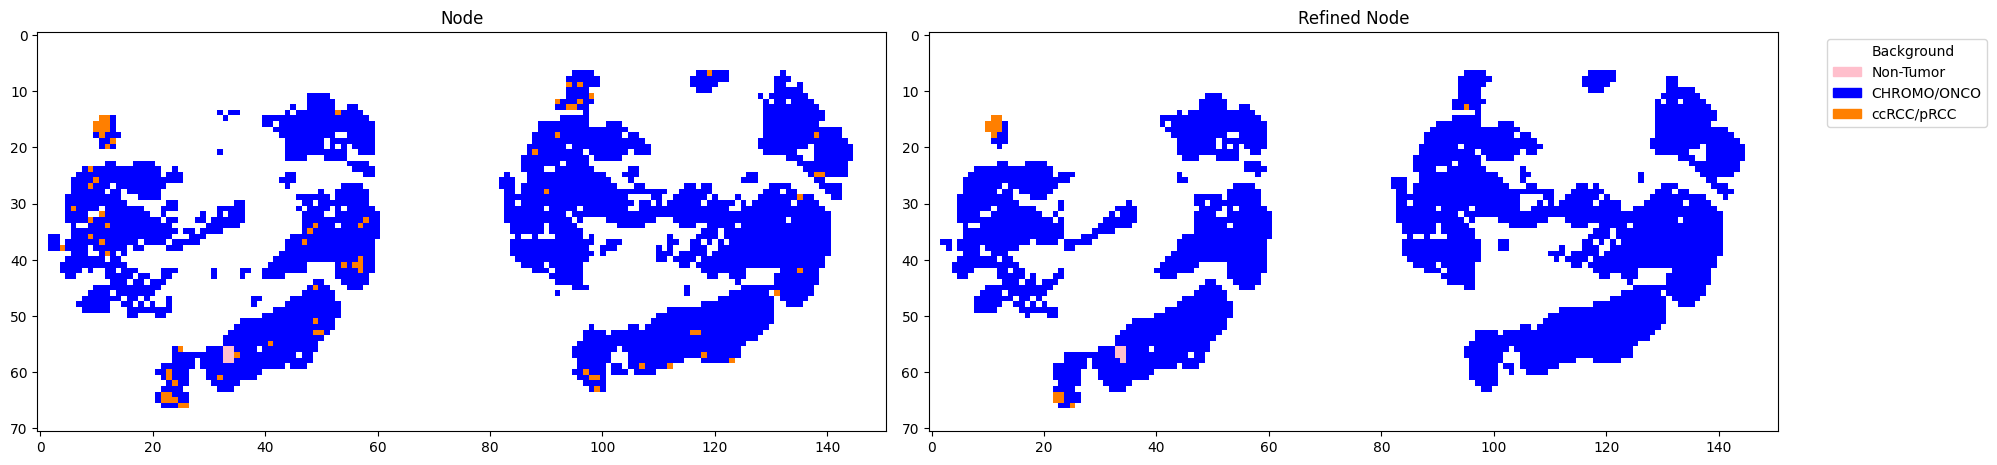

In [23]:
expertdt.plot_stage_on_slide(stage='Node')

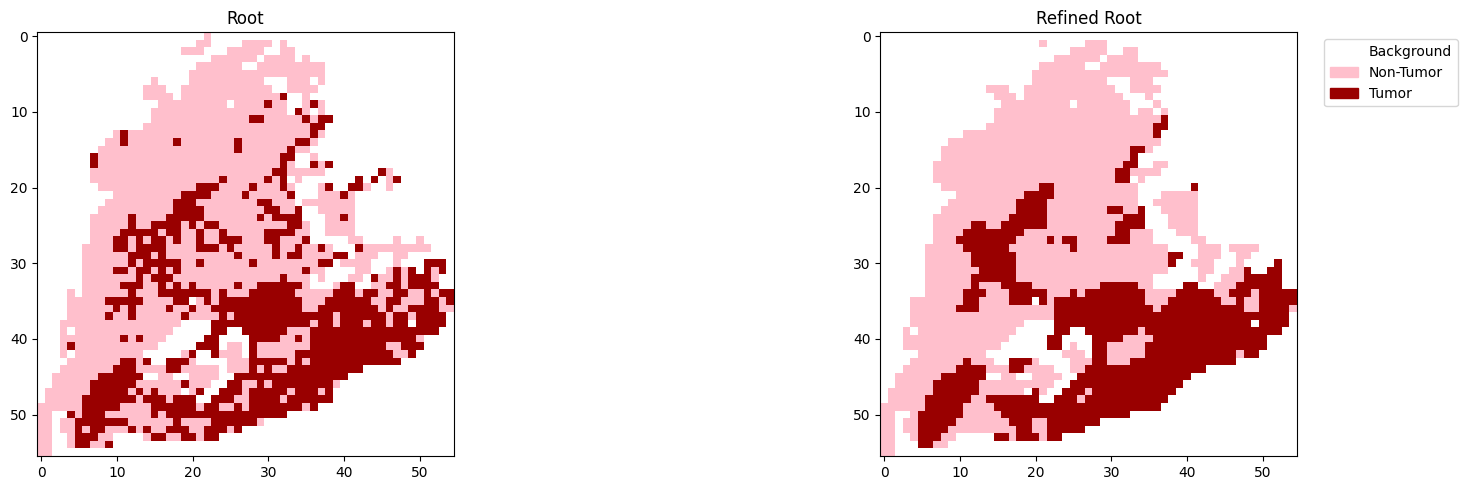

In [13]:
from skimage.transform import resize

stage = "Root"
alpha = 0.75

if stage=="Root":
    arrays = [expertdt.root_array, expertdt.root_refined_array]

elif stage=="Node":
    arrays = [expertdt.node_array, expertdt.node_refined_array]

elif stage=="Leaf1":
    arrays = [expertdt.leaf1_array, expertdt.leaf1_refined_array]

elif stage=="Leaf2":
    arrays = [expertdt.leaf2_array, expertdt.leaf2_refined_array]

stage_kwargs = PlotTree().PlotStage(stage=stage, alpha=1)

sorted_keys = sorted(stage_kwargs['label_dict'].keys(), key=int)

labels = [stage_kwargs['label_dict'][key] for key in sorted_keys]
colors = [stage_kwargs['stage_colors'][int(key)] for key in sorted_keys]

cmap = ListedColormap(colors)
bounds = [float(key) - 0.5 for key in sorted_keys] + [float(sorted_keys[-1]) + 0.5]
norm = BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(1, len(arrays), figsize=(20, 5))
for ax, array, title in zip(axes, arrays, stage_kwargs['titles']):
    im = ax.imshow(array, cmap=cmap, norm=norm)
    ax.set_title(title)

handles = [Patch(color=color, label=label) for color, label in zip(colors, labels)]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [49]:
expertdt.slide.close()

In [227]:
verbose = True

with open(f"_info/split_ids.json", 'r') as file:
    train_test_ids = json.load(file)

ids_df = pd.read_csv(f"_info/ids.csv")

In [229]:
from glob import glob

root_dir = "F:\\My Files\\Thesis\\Dataset\\RCC_WSIs\\"
wsi_formats = ['.scn', '.svs', '.tif']

results_list = []

for subtype in train_test_ids['Test'].keys():

    if verbose:
        print(f"\n")
        print(f"--"*15)
        print(f">>> Preparing Data for '{subtype}' Tests:")
        print(f"--"*15)
        print(f"\n")

    for index in train_test_ids['Test'][subtype]:

        print(f"++"*15)
        print(f">>> Patient ID: {ids_df.iloc[index].id}")
        print(f"++"*15)
        
        glob_pattern = []
        
        if subtype != "Unknown":

            subtype_path = f"F:\\My Files\\Thesis\\Dataset\\RCC_WSIs\\{subtype}"

            if glob(f"{subtype_path}\\*{ids_df.iloc[index].id}*"):
                glob_pattern = glob(f"{subtype_path}\\*{ids_df.iloc[index].id}*")

            elif glob(f"F:\\My Files\\Thesis\\Dataset\\RCC_WSIs\\pre\\{subtype}\\*{ids_df.iloc[index].id}*"):
                glob_pattern = glob(f"{args.root_dir}\\pre\\{subtype}\\*{ids_df.iloc[index].id}*")

        else:
            subtype_path = f"F:\\My Files\\Thesis\\Dataset\\2023_WSIs"
            if glob(f"{subtype_path}\\*{ids_df.iloc[index].id}*"):
                glob_pattern = glob(f"{subtype_path}\\*{ids_df.iloc[index].id}*")

        for slide_dir in glob_pattern:

            slidename = slide_dir.split("\\")[-1][:-4]
            slideformat = slide_dir.split("\\")[-1][-4:]

            result_dict = {}

            if slideformat in wsi_formats:

                print(f">>> Slide: {slidename}")

                result_dict['id'] = ids_df.iloc[index].id
                result_dict['subtype'] = subtype
                result_dict['slide'] = slidename
                result_dict['format'] = slideformat

                expertdt = ExpertDT(crop_size=1000,
                                    crop_resize=112,
                                    level=0,
                                    overlap=1,
                                    batch_size=128,
                                    weights_dir="F:\My Files\Thesis\Dataset\_weights",
                                    tree_pair_dir="_info",
                                    pruned_threshold=30)
                
                expertdt.predict(slide_dir=slide_dir)
                
                result_dict['node_pruned'] = expertdt.stages_status['Node']=='Pruned'
                result_dict['ccRCC'] = expertdt.subtype_counts['ccRCC']
                result_dict['pRCC'] = expertdt.subtype_counts['pRCC']
                result_dict['CHROMO'] = expertdt.subtype_counts['CHROMO']
                result_dict['ONCOCYTOMA'] = expertdt.subtype_counts['ONCOCYTOMA']
                result_dict['result'] = expertdt.max_subtype

                results_list.append(result_dict)

        results_df = pd.DataFrame(results_list)
        results_df.to_csv('_res/expertdt_results.csv', index=False)       



------------------------------
>>> Preparing Data for 'ccRCC' Tests:
------------------------------


++++++++++++++++++++++++++++++
>>> Patient ID: HP12.3187
++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++
>>> Patient ID: HP13.1799
++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++
>>> Patient ID: H19.754
++++++++++++++++++++++++++++++
>>> Slide: H19.754.IHC.ccRCC
>>> Start Slide Analysis ...
[Step 1/4] >>> Cropping WSI into patches ...


100%|██████████| 3080/3080 [01:12<00:00, 42.65it/s]


>>> Succesfully Loaded Weights ...
[Step 2/4] >>> Root Stage Analysis ...


100%|██████████| 3080/3080 [02:21<00:00, 21.73it/s]


>>> Succesfully Loaded Weights ...
[Step 3/4] >>> Node Stage Analysis ...


100%|██████████| 3080/3080 [00:50<00:00, 61.53it/s] 


--- >>> Node Confidence: : 100.0%, Node to Leaf 2
>>> Succesfully Loaded Weights ...
[Step 4/4] >>> Leaf Stage Analysis: Leaf 2 ...


100%|██████████| 3080/3080 [00:49<00:00, 62.61it/s] 


>>> Results:
>>> Slide Label: ccRCC
>>> Subtype Count:
 {'ccRCC': 572, 'pRCC': 0, 'CHROMO': 0, 'ONCOCYTOMA': 0}
++++++++++++++++++++++++++++++
>>> Patient ID: HP10.2986
++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++
>>> Patient ID: HP12.13358
++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++
>>> Patient ID: HP12.6073
++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++
>>> Patient ID: HP12.7225
++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++
>>> Patient ID: HP12.8355
++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++
>>> Patient ID: HP12.8793
++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++
>>> Patient ID: HP12.9282
++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++
>>> Patient ID: HP14.1749
++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++
>>> Patient ID: HP14.1993
++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++
>>> Patient ID: HP15.11259
++++++++++++++++++++++++++++++
++++++

100%|██████████| 11468/11468 [05:00<00:00, 38.14it/s]


>>> Succesfully Loaded Weights ...
[Step 2/4] >>> Root Stage Analysis ...


100%|██████████| 11468/11468 [10:43<00:00, 17.81it/s] 


>>> Succesfully Loaded Weights ...
[Step 3/4] >>> Node Stage Analysis ...


100%|██████████| 11468/11468 [08:32<00:00, 22.40it/s] 


--- >>> Node Confidence: : 99.46%, Node to Leaf 2
>>> Succesfully Loaded Weights ...
[Step 4/4] >>> Leaf Stage Analysis: Leaf 2 ...


100%|██████████| 11468/11468 [08:11<00:00, 23.32it/s] 


>>> Results:
>>> Slide Label: ccRCC
>>> Subtype Count:
 {'ccRCC': 5735, 'pRCC': 129, 'CHROMO': 0, 'ONCOCYTOMA': 0}
>>> Slide: HP19.10064.A1.ccRCC
>>> Start Slide Analysis ...
[Step 1/4] >>> Cropping WSI into patches ...


100%|██████████| 10980/10980 [04:52<00:00, 37.58it/s]


>>> Succesfully Loaded Weights ...
[Step 2/4] >>> Root Stage Analysis ...


100%|██████████| 10980/10980 [10:12<00:00, 17.92it/s]


>>> Succesfully Loaded Weights ...
[Step 3/4] >>> Node Stage Analysis ...


100%|██████████| 10980/10980 [06:59<00:00, 26.16it/s] 


--- >>> Node Confidence: : 99.51%, Node to Leaf 2
>>> Succesfully Loaded Weights ...
[Step 4/4] >>> Leaf Stage Analysis: Leaf 2 ...


100%|██████████| 10980/10980 [08:23<00:00, 21.82it/s] 


>>> Results:
>>> Slide Label: ccRCC
>>> Subtype Count:
 {'ccRCC': 5550, 'pRCC': 100, 'CHROMO': 0, 'ONCOCYTOMA': 0}
>>> Slide: HP19.10064.A10.ccRCC
>>> Start Slide Analysis ...
[Step 1/4] >>> Cropping WSI into patches ...


100%|██████████| 8325/8325 [03:52<00:00, 35.80it/s]


>>> Succesfully Loaded Weights ...
[Step 2/4] >>> Root Stage Analysis ...


100%|██████████| 8325/8325 [09:13<00:00, 15.05it/s]


>>> Succesfully Loaded Weights ...
[Step 3/4] >>> Node Stage Analysis ...


100%|██████████| 8325/8325 [06:53<00:00, 20.15it/s] 


--- >>> Node Confidence: : 97.58%, Node to Leaf 2
>>> Succesfully Loaded Weights ...
[Step 4/4] >>> Leaf Stage Analysis: Leaf 2 ...


100%|██████████| 8325/8325 [06:29<00:00, 21.37it/s] 


>>> Results:
>>> Slide Label: ccRCC
>>> Subtype Count:
 {'ccRCC': 2467, 'pRCC': 2228, 'CHROMO': 0, 'ONCOCYTOMA': 0}
>>> Slide: HP19.10064.A13.ccRCC
>>> Start Slide Analysis ...
[Step 1/4] >>> Cropping WSI into patches ...


100%|██████████| 6364/6364 [02:58<00:00, 35.64it/s]


>>> Succesfully Loaded Weights ...
[Step 2/4] >>> Root Stage Analysis ...


100%|██████████| 6364/6364 [08:13<00:00, 12.91it/s]


>>> Succesfully Loaded Weights ...
[Step 3/4] >>> Node Stage Analysis ...


100%|██████████| 6364/6364 [03:19<00:00, 31.86it/s] 


--- >>> Node Confidence: : 99.76%, Node to Leaf 2
>>> Succesfully Loaded Weights ...
[Step 4/4] >>> Leaf Stage Analysis: Leaf 2 ...


100%|██████████| 6364/6364 [03:20<00:00, 31.79it/s] 


>>> Results:
>>> Slide Label: ccRCC
>>> Subtype Count:
 {'ccRCC': 2429, 'pRCC': 82, 'CHROMO': 0, 'ONCOCYTOMA': 0}
>>> Slide: HP19.10064.A14.ccRCC
>>> Start Slide Analysis ...
[Step 1/4] >>> Cropping WSI into patches ...


100%|██████████| 1548/1548 [00:39<00:00, 39.19it/s]


>>> Succesfully Loaded Weights ...
[Step 2/4] >>> Root Stage Analysis ...


100%|██████████| 1548/1548 [01:30<00:00, 17.16it/s]


>>> Succesfully Loaded Weights ...
[Step 3/4] >>> Node Stage Analysis ...


100%|██████████| 1548/1548 [01:11<00:00, 21.76it/s]


--- >>> Node Confidence: : 92.55%, Node to Leaf 2
>>> Succesfully Loaded Weights ...
[Step 4/4] >>> Leaf Stage Analysis: Leaf 2 ...


100%|██████████| 1548/1548 [01:06<00:00, 23.32it/s]


>>> Results:
>>> Slide Label: ccRCC
>>> Subtype Count:
 {'ccRCC': 527, 'pRCC': 338, 'CHROMO': 0, 'ONCOCYTOMA': 0}
>>> Slide: HP19.10064.A16.ccRCC
>>> Start Slide Analysis ...
[Step 1/4] >>> Cropping WSI into patches ...


100%|██████████| 5740/5740 [02:29<00:00, 38.43it/s]


>>> Succesfully Loaded Weights ...
[Step 2/4] >>> Root Stage Analysis ...


100%|██████████| 5740/5740 [06:13<00:00, 15.35it/s]


>>> Succesfully Loaded Weights ...
[Step 3/4] >>> Node Stage Analysis ...


 42%|████▏     | 2407/5740 [00:21<00:30, 109.96it/s]


KeyboardInterrupt: 

In [192]:
expertdt.max_subtype

'pRCC'

### Manual Tests

In [90]:
vgg16 = Vgg16(input_shape=(expertdt.crop_resize, expertdt.crop_resize, 3),
                n_classes=expertdt.n_classes,
                first_trained_layer=expertdt.first_trained_layer)

vgg16.load_weights(weights_path=f"{expertdt.weights_dir}\Root\{expertdt.final_weights['Root']}")

expertdt.root_array = expertdt.slide_array.copy()

for patch_index in tqdm(range(len(expertdt.patches_dict))):

    if not expertdt.patches_dict[patch_index]['label']==-1:

        region = expertdt.slide.read_region([expertdt.patches_dict[patch_index]['left'],
                                    expertdt.patches_dict[patch_index]['top']],
                                expertdt.level,
                                [expertdt.patches_dict[patch_index]['size'],
                                    expertdt.patches_dict[patch_index]['size']])

        region = region.convert('RGB').resize(size=(expertdt.crop_resize, expertdt.crop_resize))
        image_array = np.array(region) / 255.0

        pred_label = vgg16.predict(input=image_array)
        pred_class = np.argmax(pred_label[0])

        expertdt.root_array[expertdt.patches_dict[patch_index]['y'], expertdt.patches_dict[patch_index]['x']] = pred_class

Model weights loaded from: F:\My Files\Thesis\Dataset\_weights\Root\model_epoch_90.h5


100%|██████████| 3080/3080 [04:07<00:00, 12.44it/s]


Init Value Counts:  {-1.0: 1391, 0.0: 1801}
Before Refinement Root Value Counts:  {-1.0: 1391, 0.0: 1181, 1.0: 620}
After Refinement Root Value Counts:  {-1.0: 1405, 0.0: 1192, 1.0: 595}


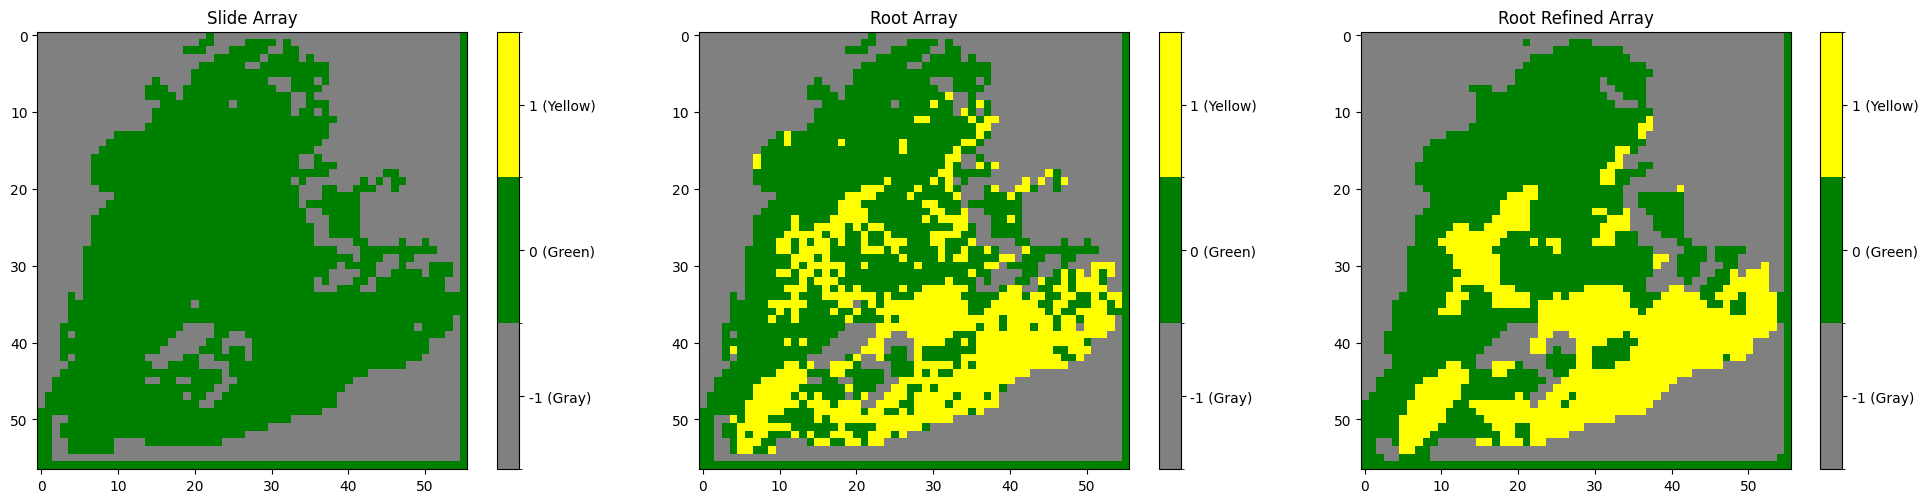

In [102]:
unique_values, counts = np.unique(expertdt.slide_array, return_counts=True)
value_counts = dict(zip(unique_values, counts))

print("Init Value Counts: ", value_counts)

unique_values, counts = np.unique(expertdt.root_array, return_counts=True)
value_counts = dict(zip(unique_values, counts))

print("Before Refinement Root Value Counts: ", value_counts)

root_refined_array = refine_output(expertdt.root_array)

unique_values, counts = np.unique(root_refined_array, return_counts=True)
value_counts = dict(zip(unique_values, counts))

print("After Refinement Root Value Counts: ", value_counts)

# Arrays to plot
arrays = [expertdt.slide_array, expertdt.root_array, root_refined_array]
titles = ['Slide Array', 'Root Array', 'Root Refined Array']

# Plotting
plot_arrays(arrays, titles)

In [21]:
vgg16 = Vgg16(input_shape=(expertdt.crop_resize, expertdt.crop_resize, 3),
                n_classes=expertdt.n_classes,
                first_trained_layer=expertdt.first_trained_layer)

expertdt.load_tree_weights()
vgg16.load_weights(weights_path=fr"{expertdt.weights_dir}\Node\{expertdt.final_weights['Node']}")

expertdt.node_array = expertdt.root_refined_array.copy()

print(">>> Node Stage Analysis ...")

for patch_index in tqdm(range(len(expertdt.patches_dict))):

    root_crop_label = expertdt.root_array[expertdt.patches_dict[patch_index]['y'], expertdt.patches_dict[patch_index]['x']]
    node_condition = expertdt.patches_dict[patch_index]['label']!=-1 and root_crop_label!=0

    if node_condition:
    
        region = expertdt.slide.read_region([expertdt.patches_dict[patch_index]['left'],
                                    expertdt.patches_dict[patch_index]['top']],
                                expertdt.level,
                                [expertdt.patches_dict[patch_index]['size'],
                                    expertdt.patches_dict[patch_index]['size']])

        region = region.convert('RGB').resize(size=(expertdt.crop_resize, expertdt.crop_resize))
        image_array = np.array(region) / 255.0

        pred_label = vgg16.predict(input=image_array)
        pred_class = np.argmax(pred_label[0])

        expertdt.node_array[expertdt.patches_dict[patch_index]['y'], expertdt.patches_dict[patch_index]['x']] = pred_class+1

expertdt.node_refined_array = expertdt.refine_output(expertdt.node_array)

>>> Succesfully Loaded Weights ...
>>> Node Stage Analysis ...


100%|██████████| 3080/3080 [01:22<00:00, 37.49it/s] 


In [31]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# ['-1 (Gray)', '0 (Green)', '1 (Yellow)']
yticks = ['-1 (Background)', '1 (ccRCC/pRCC)', '2 (CHROMO/ONCO)']

def _refine(input):
    
    central = input[input.size // 2]
    values, counts = np.unique(input, return_counts=True)
    max_freq = counts.max()
    modes = values[counts == max_freq]

    if central in modes:
        return central
    else:
        return modes[0]
    
def refine_output(input_crops, size=(3, 3)):

    refined_crops = ndimage.generic_filter(input_crops, _refine, size=size, mode='nearest')

    return refined_crops

# Custom colormap: -1 to gray, 0 to green, 1 to yellow
colors = ['gray', 'green', 'blue', 'red']
cmap = ListedColormap(colors)
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]  # Defines the boundaries between colors
norm = BoundaryNorm(bounds, cmap.N)

# Function to plot arrays with custom color mapping
def plot_arrays(arrays, titles):
    fig, axes = plt.subplots(1, len(arrays), figsize=(20, 5))
    for ax, array, title in zip(axes, arrays, titles):
        im = ax.imshow(array, cmap=cmap, norm=norm)
        ax.set_title(title)
        # Create colorbar with custom ticks and labels for each color segment
        cbar = fig.colorbar(im, ax=ax, ticks=[-1, 1, 3], orientation='vertical')
        cbar.ax.set_yticklabels(yticks)
    plt.tight_layout()
    plt.show()

Init Value Counts:  {-1.0: 1458, 0.0: 1029, 1.0: 593}
Before Refinement Root Value Counts:  {-1.0: 1436, 0.0: 923, 1.0: 720, 2.0: 1}
After Refinement Root Value Counts:  {-1.0: 1486, 0.0: 917, 1.0: 677}


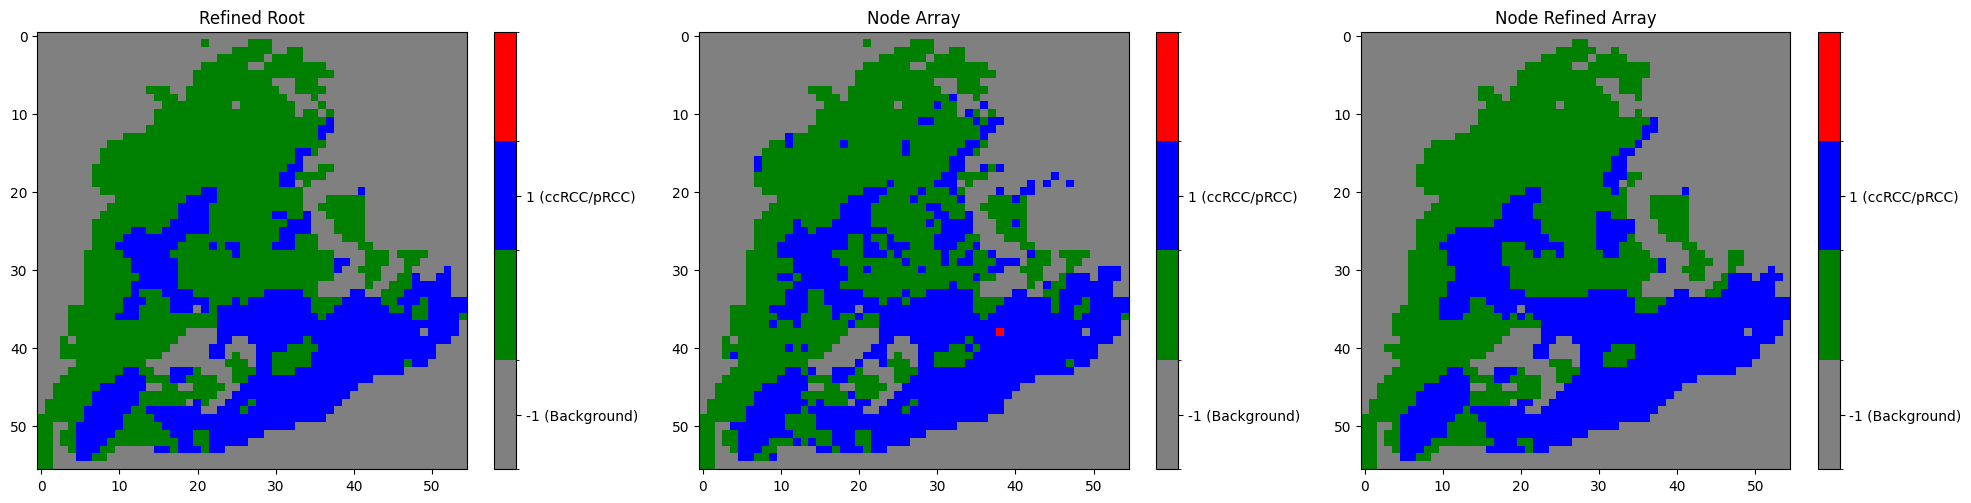

In [32]:
unique_values, counts = np.unique(expertdt.root_refined_array, return_counts=True)
value_counts = dict(zip(unique_values, counts))

print("Init Value Counts: ", value_counts)

unique_values, counts = np.unique(expertdt.node_array, return_counts=True)
value_counts = dict(zip(unique_values, counts))

print("Before Refinement Root Value Counts: ", value_counts)

root_refined_array = refine_output(expertdt.root_array)

unique_values, counts = np.unique(expertdt.node_refined_array, return_counts=True)
value_counts = dict(zip(unique_values, counts))

print("After Refinement Root Value Counts: ", value_counts)

# Arrays to plot
arrays = [expertdt.root_refined_array, expertdt.node_array, expertdt.node_refined_array]
titles = ['Refined Root', 'Node Array', 'Node Refined Array']

# Plotting
plot_arrays(arrays, titles)

In [65]:
patches_df = pd.DataFrame(expertdt.patches_dict)

In [66]:
patches_df[patches_df['label']!=-1]

,x,y,top,left,size,label
22,22,0,132286,57745,1000,0
76,21,1,133286,56745,1000,0
77,22,1,133286,57745,1000,0
82,27,1,133286,62745,1000,0
83,28,1,133286,63745,1000,0
...,...,...,...,...,...,...
2977,7,54,186286,42745,1000,0
2978,8,54,186286,43745,1000,0
2979,9,54,186286,44745,1000,0
3025,0,55,187286,35745,1000,0


# Changed Parts

In [ ]:
    # def init_patches(self, slide_dir):

    #     # Load Slide
    #     self.slide = openslide.OpenSlide(slide_dir)
    #     downsample = self.slide.level_downsamples[self.level]

    #     # Check if slide has bound-width properties
    #     if 'openslide.bounds-width' in self.slide.properties.keys():
    #         self.bounds_width = int(self.slide.properties['openslide.bounds-width'])
    #         self.bounds_height = int(self.slide.properties['openslide.bounds-height'])
    #         bounds_x = int(self.slide.properties['openslide.bounds-x'])
    #         bounds_y = int(self.slide.properties['openslide.bounds-y'])
    #     else:
    #         self.bounds_width = self.slide.dimensions[0]
    #         self.bounds_height = self.slide.dimensions[1]
    #         bounds_x = 0
    #         bounds_y = 0

    #     _step_ = int(self.crop_size / self.overlap)
    #     _size_ = math.floor(self.crop_size / downsample)
    #     _y_steps_ = int(math.ceil((self.bounds_height - self.crop_size) / _step_))
    #     _x_steps_ = int(math.ceil((self.bounds_width - self.crop_size) / _step_))

    #     self.patches_dict = []
    #     self.slide_array = np.zeros((_y_steps_, _x_steps_))

    #     y_index = 0

    #     total_iterations = _y_steps_ * _x_steps_

    #     print(">>> Cropping WSI into patches ...")

    #     with tqdm(total=total_iterations) as pbar:

    #         # N.B. Crops are considered in the 0 level
    #         for y in range(_y_steps_):

    #             x_index = 0
    #             for x in range(_x_steps_):

    #                 pbar.update(1)
                    
    #                 if x * _step_ + self.crop_size > self.bounds_width or y * _step_ + self.crop_size > self.bounds_height:
    #                     continue
                    
    #                 # Top and left boundaries
    #                 _top_ = _step_ * y + bounds_y
    #                 _left_ = _step_ * x + bounds_x
                    
    #                 # Create patch dictionary
    #                 _patch_ = {
    #                             'x':x_index ,
    #                             'y':y_index,
    #                             'top': _top_,
    #                             'left':_left_,
    #                             'size': _size_
    #                             }
                    
    #                 if not self.check_background(_patch_):
    #                     _label_ = 0
                        
    #                 else:
    #                     _label_ = -1

    #                 _patch_['label'] = _label_
    #                 self.slide_array[y_index, x_index] = _label_
    #                 self.patches_dict.append(_patch_)

    #                 x_index += 1

    #             y_index += 1

    #     self.patches_dict = list(self.patches_dict)












    # def predict_node(self):

    #     if not self.check_stage_requirement(stage="Node"):
    #         print("[WARNING] No Root Analysis Found ...")
    #     else:  
    #         vgg16 = Vgg16(input_shape=(self.crop_resize, self.crop_resize, 3),
    #                         n_classes=self.n_classes,
    #                         first_trained_layer=self.first_trained_layer)
            
    #         self.load_tree_weights()
    #         vgg16.load_weights(weights_path=fr"{self.weights_dir}\Node\{self.final_weights['Node']}")

    #         self.node_array = self.root_refined_array.copy()

    #         print(">>> Node Stage Analysis ...")

    #         for patch_index in tqdm(range(len(self.patches_dict))):

    #             root_crop_label = self.root_refined_array[self.patches_dict[patch_index]['y'], self.patches_dict[patch_index]['x']]
    #             node_condition = self.patches_dict[patch_index]['label']!=-1 and root_crop_label==1

    #             if node_condition:
                
    #                 region = self.slide.read_region([self.patches_dict[patch_index]['left'],
    #                                             self.patches_dict[patch_index]['top']],
    #                                         self.level,
    #                                         [self.patches_dict[patch_index]['size'],
    #                                             self.patches_dict[patch_index]['size']])

    #                 region = region.convert('RGB').resize(size=(self.crop_resize, self.crop_resize))
    #                 image_array = np.array(region) / 255.0

    #                 pred_label = vgg16.predict(input=image_array)
    #                 pred_class = np.argmax(pred_label[0])

    #                 if pred_class==0:
    #                     node_label = 2
    #                 else:
    #                     node_label = 1

    #                 self.node_array[self.patches_dict[patch_index]['y'], self.patches_dict[patch_index]['x']] = node_label

    #         self.node_refined_array = self.refine_output(self.node_array)

    #         # Find the path to leaf1 of leaf2 based on majority voting
    #         unique_values, counts = np.unique(self.node_refined_array, return_counts=True)
    #         value_counts = dict(zip(unique_values, counts))

    #         # Count number of patches of two node super classes
    #         node_count_1, node_count_2 = value_counts.get(1, 0), value_counts.get(2, 0)

    #         # Compute the difference percentage between two super classes

    #         node_cert = round(abs(node_count_1 - node_count_2) / (node_count_1 + node_count_2) * 100, 2)

    #         # Check node pruning
    #         if node_cert >= self.node_pruned_threshold:

    #             # Determine the majority label
    #             node_majority = 1 if node_count_1 > node_count_2 else 2
    #             print(f"--- >>> Node Confidence %: : {node_cert}%, Node Label: {node_majority}")
    #             self.stages_status['Node'] = f'Leaf{node_majority}' 
    #         else:
    #             self.stages_status['Node'] = 'Pruned'
    #             print("--- >>> Node is Pruned! Connecting Root Directly to Leafs ...")

            